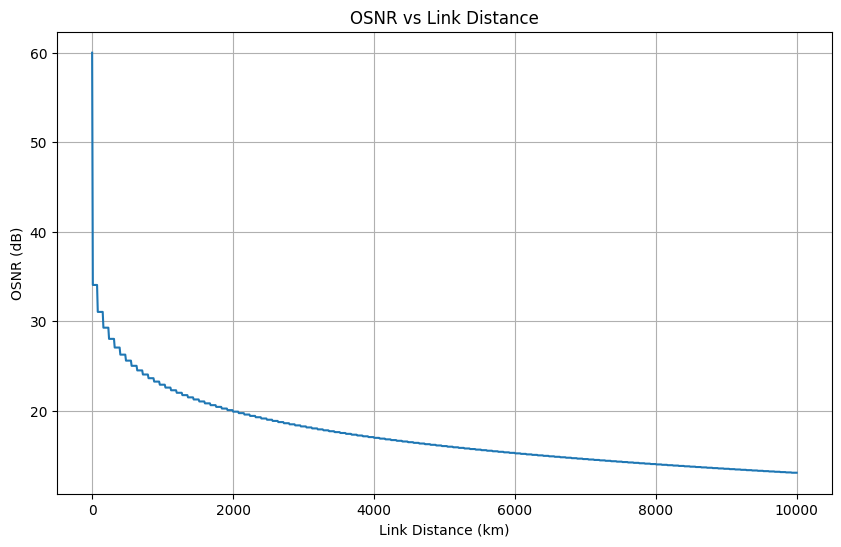

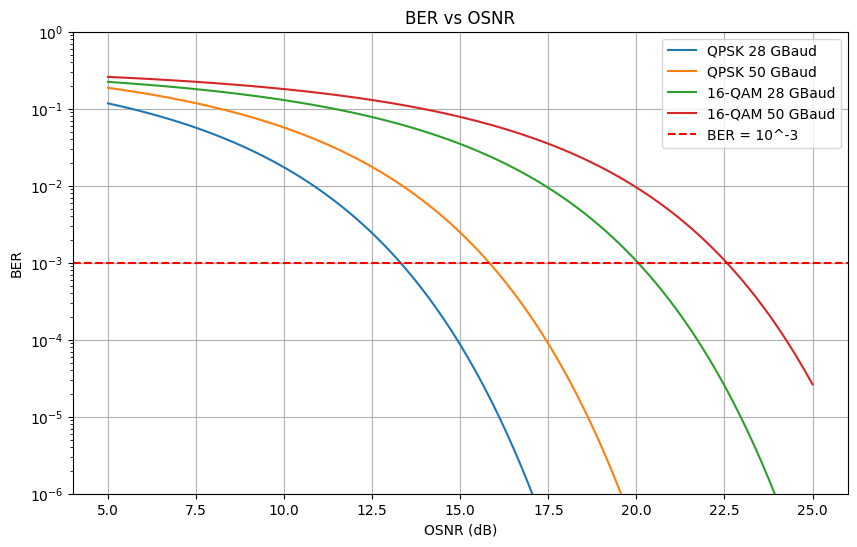

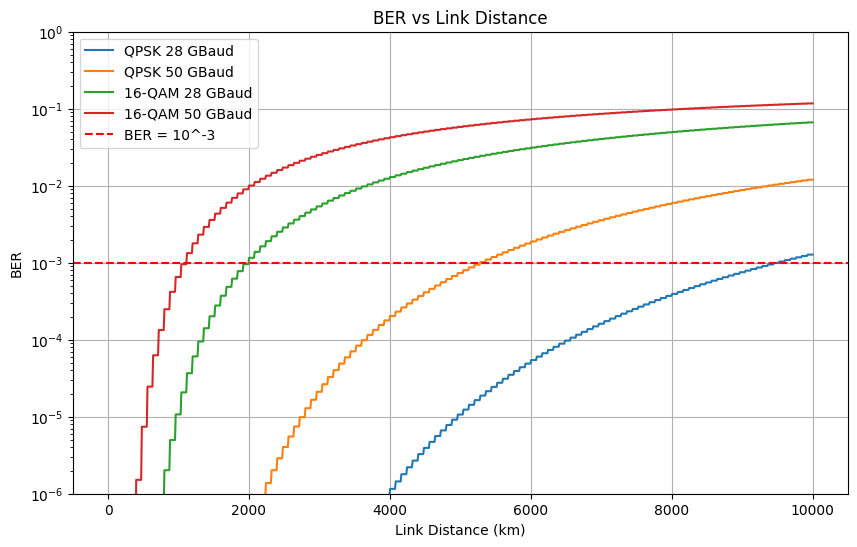

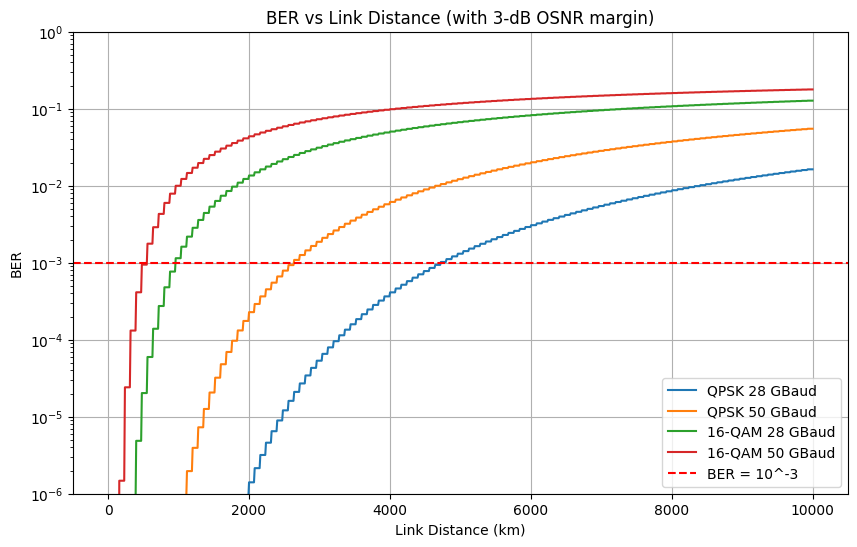


(e) System reaches for BER = 10^-3:
QPSK 28 GBaud: 9521.43 km
QPSK 50 GBaud: 5282.77 km
16-QAM 28 GBaud: 1994.36 km
16-QAM 50 GBaud: 1112.48 km

(f) System reaches for BER = 10^-3 with 3-dB OSNR margin:
QPSK 28 GBaud: 4722.12 km
QPSK 50 GBaud: 2637.23 km
16-QAM 28 GBaud: 957.58 km
16-QAM 50 GBaud: 551.46 km


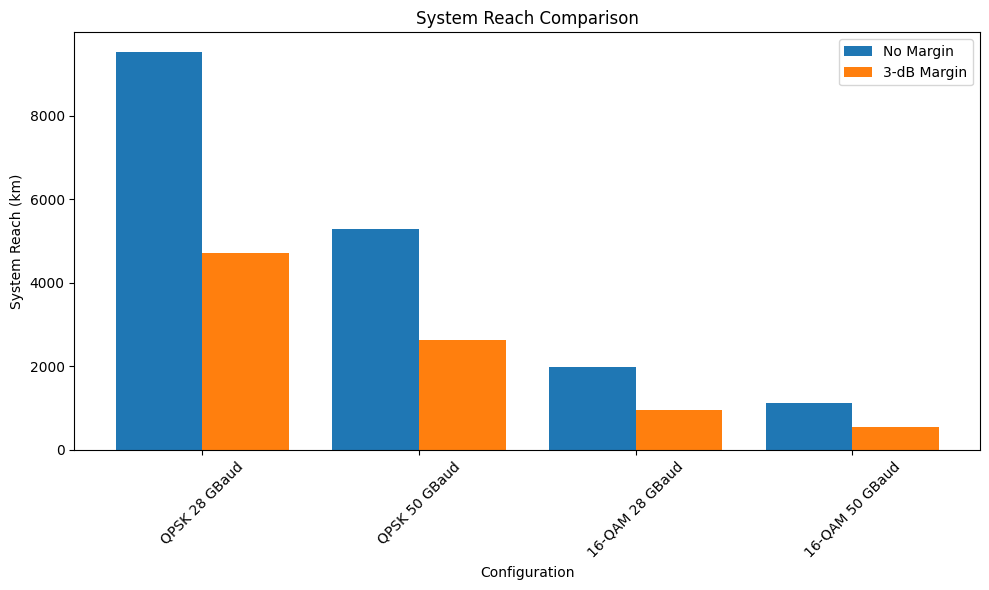


Comprehensive Summary:
----------------------------------------------------------------------
Configuration   | Reach (km)      | Reach with 3-dB margin (km)   
----------------------------------------------------------------------
QPSK 28 GBaud   | 9521.43         | 4722.12                       
QPSK 50 GBaud   | 5282.77         | 2637.23                       
16-QAM 28 GBaud | 1994.36         | 957.58                        
16-QAM 50 GBaud | 1112.48         | 551.46                        
----------------------------------------------------------------------


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import math

# System parameters
Ls = 80  # Span length in km
Ns = 125  # Number of spans
Psignal_dBm = 0  # Transmit power in dBm
alpha_dB_km = 0.2  # Attenuation constant in dB/km
nu = 193.1e12  # Operating frequency in Hz
h = 6.62e-34  # Planck's constant in J·s
NF_dB = 5  # Amplifier noise figure in dB
polarization_multiplexing = True  # Polarization Multiplexing

# Convert dBm to linear power (W)
Psignal = 10**(Psignal_dBm/10) * 1e-3  # W

# Convert attenuation from dB/km to linear 1/km
alpha = alpha_dB_km / (10 * np.log10(np.e))  # 1/km

# Convert noise figure from dB to linear
NF_linear = 10**(NF_dB/10)

# Function to calculate OSNR based on link distance
def calculate_OSNR(distance_km):
    num_spans = distance_km / Ls
    # If not an integer number of spans, round up
    num_spans = np.ceil(num_spans)

    # OSNR calculation
    # For amplified system with identical spans
    # OSNR = Psignal / (num_spans * Pase)
    # where Pase = h * nu * NF_linear * (G-1) * B (G is gain, B is bandwidth)
    # For simplicity, assume G = exp(alpha * Ls) to compensate for span loss

    G = np.exp(alpha * Ls)
    Pase_factor = h * nu * NF_linear * (G-1)

    # Reference bandwidth is 0.1 nm at 1550 nm wavelength
    # 0.1 nm at 1550 nm is approximately 12.5 GHz
    B_ref = 12.5e9  # Hz

    # Calculate ASE noise power
    Pase = Pase_factor * B_ref

    # OSNR calculation (assuming polarization multiplexing if enabled)
    if polarization_multiplexing:
        # For PM, signal power is split between two polarizations
        OSNR = (Psignal/2) / (num_spans * Pase)
    else:
        OSNR = Psignal / (num_spans * Pase)

    return OSNR

# Function to convert OSNR to dB
def OSNR_to_dB(OSNR):
    return 10 * np.log10(OSNR)

# Function to calculate BER for QPSK
def calculate_BER_QPSK(OSNR_dB, symbol_rate):
    # Convert OSNR from dB to linear
    OSNR_linear = 10**(OSNR_dB/10)

    # Reference bandwidth is 0.1 nm (12.5 GHz)
    B_ref = 12.5e9  # Hz

    # Adjust OSNR for the actual symbol rate
    # For QPSK with PM, each symbol carries 4 bits (2 bits × 2 polarizations)
    # Signal bandwidth = symbol_rate
    OSNR_adjusted = OSNR_linear * (B_ref / symbol_rate)

    # For QPSK with PM, BER ≈ 0.5 * erfc(sqrt(OSNR_adjusted))
    Es_N0 = OSNR_adjusted
    BER = 0.5 * erfc(np.sqrt(Es_N0/2))

    return BER

# Function to calculate BER for 16-QAM
def calculate_BER_16QAM(OSNR_dB, symbol_rate):
    # Convert OSNR from dB to linear
    OSNR_linear = 10**(OSNR_dB/10)

    # Reference bandwidth is 0.1 nm (12.5 GHz)
    B_ref = 12.5e9  # Hz

    # Adjust OSNR for the actual symbol rate
    # For 16-QAM with PM, each symbol carries 8 bits (4 bits × 2 polarizations)
    # Signal bandwidth = symbol_rate
    OSNR_adjusted = OSNR_linear * (B_ref / symbol_rate)

    # For 16-QAM with PM, approximate BER
    # Using the approximation BER ≈ 3/8 * erfc(sqrt(OSNR_adjusted/10))
    Es_N0 = OSNR_adjusted
    BER = 3/8 * erfc(np.sqrt(Es_N0/10))

    return BER

# Define the distance range (0 to total link length)
total_link_length = Ls * Ns  # km
distance_points = 1000
distance_range = np.linspace(0, total_link_length, distance_points)

# Calculate OSNR for each distance
OSNR_values = []
for distance in distance_range:
    if distance == 0:
        # At the transmitter, assume very high OSNR (limited by practical considerations)
        OSNR_values.append(60)  # Arbitrary high value in dB
    else:
        OSNR = calculate_OSNR(distance)
        OSNR_values.append(OSNR_to_dB(OSNR))

OSNR_values = np.array(OSNR_values)

# (a) Plot OSNR vs distance
plt.figure(figsize=(10, 6))
plt.plot(distance_range, OSNR_values)
plt.title('OSNR vs Link Distance')
plt.xlabel('Link Distance (km)')
plt.ylabel('OSNR (dB)')
plt.grid(True)
plt.savefig('OSNR_vs_distance.png')
plt.show()

# (b) Plot BER vs OSNR for different modulation formats and symbol rates
OSNR_dB_range = np.linspace(5, 25, 100)

# Calculate BER for different modulation formats and symbol rates
BER_QPSK_28G = [calculate_BER_QPSK(osnr, 28e9) for osnr in OSNR_dB_range]
BER_QPSK_50G = [calculate_BER_QPSK(osnr, 50e9) for osnr in OSNR_dB_range]
BER_16QAM_28G = [calculate_BER_16QAM(osnr, 28e9) for osnr in OSNR_dB_range]
BER_16QAM_50G = [calculate_BER_16QAM(osnr, 50e9) for osnr in OSNR_dB_range]

plt.figure(figsize=(10, 6))
plt.semilogy(OSNR_dB_range, BER_QPSK_28G, label='QPSK 28 GBaud')
plt.semilogy(OSNR_dB_range, BER_QPSK_50G, label='QPSK 50 GBaud')
plt.semilogy(OSNR_dB_range, BER_16QAM_28G, label='16-QAM 28 GBaud')
plt.semilogy(OSNR_dB_range, BER_16QAM_50G, label='16-QAM 50 GBaud')
plt.axhline(y=1e-3, color='r', linestyle='--', label='BER = 10^-3')
plt.title('BER vs OSNR')
plt.xlabel('OSNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.legend()
plt.ylim(1e-6, 1)
plt.savefig('BER_vs_OSNR.png')
plt.show()

# (c) Plot BER vs distance for different modulation formats and symbol rates
BER_vs_distance_QPSK_28G = []
BER_vs_distance_QPSK_50G = []
BER_vs_distance_16QAM_28G = []
BER_vs_distance_16QAM_50G = []

for osnr in OSNR_values:
    BER_vs_distance_QPSK_28G.append(calculate_BER_QPSK(osnr, 28e9))
    BER_vs_distance_QPSK_50G.append(calculate_BER_QPSK(osnr, 50e9))
    BER_vs_distance_16QAM_28G.append(calculate_BER_16QAM(osnr, 28e9))
    BER_vs_distance_16QAM_50G.append(calculate_BER_16QAM(osnr, 50e9))

plt.figure(figsize=(10, 6))
plt.semilogy(distance_range, BER_vs_distance_QPSK_28G, label='QPSK 28 GBaud')
plt.semilogy(distance_range, BER_vs_distance_QPSK_50G, label='QPSK 50 GBaud')
plt.semilogy(distance_range, BER_vs_distance_16QAM_28G, label='16-QAM 28 GBaud')
plt.semilogy(distance_range, BER_vs_distance_16QAM_50G, label='16-QAM 50 GBaud')
plt.axhline(y=1e-3, color='r', linestyle='--', label='BER = 10^-3')
plt.title('BER vs Link Distance')
plt.xlabel('Link Distance (km)')
plt.ylabel('BER')
plt.grid(True)
plt.legend()
plt.ylim(1e-6, 1)
plt.savefig('BER_vs_distance.png')
plt.show()

# (d) Repeat (c) with 3-dB OSNR margin
OSNR_values_with_margin = OSNR_values - 3  # Subtract 3 dB margin

BER_vs_distance_margin_QPSK_28G = []
BER_vs_distance_margin_QPSK_50G = []
BER_vs_distance_margin_16QAM_28G = []
BER_vs_distance_margin_16QAM_50G = []

for osnr in OSNR_values_with_margin:
    BER_vs_distance_margin_QPSK_28G.append(calculate_BER_QPSK(osnr, 28e9))
    BER_vs_distance_margin_QPSK_50G.append(calculate_BER_QPSK(osnr, 50e9))
    BER_vs_distance_margin_16QAM_28G.append(calculate_BER_16QAM(osnr, 28e9))
    BER_vs_distance_margin_16QAM_50G.append(calculate_BER_16QAM(osnr, 50e9))

plt.figure(figsize=(10, 6))
plt.semilogy(distance_range, BER_vs_distance_margin_QPSK_28G, label='QPSK 28 GBaud')
plt.semilogy(distance_range, BER_vs_distance_margin_QPSK_50G, label='QPSK 50 GBaud')
plt.semilogy(distance_range, BER_vs_distance_margin_16QAM_28G, label='16-QAM 28 GBaud')
plt.semilogy(distance_range, BER_vs_distance_margin_16QAM_50G, label='16-QAM 50 GBaud')
plt.axhline(y=1e-3, color='r', linestyle='--', label='BER = 10^-3')
plt.title('BER vs Link Distance (with 3-dB OSNR margin)')
plt.xlabel('Link Distance (km)')
plt.ylabel('BER')
plt.grid(True)
plt.legend()
plt.ylim(1e-6, 1)
plt.savefig('BER_vs_distance_with_margin.png')
plt.show()

# (e) Calculate system reaches for BER = 10^-3
def find_system_reach(BER_array, distance_array, target_BER=1e-3):
    # Find the index where BER crosses the target
    for i in range(len(BER_array)):
        if BER_array[i] > target_BER:
            if i > 0:
                # Linear interpolation between points
                d1 = distance_array[i-1]
                d2 = distance_array[i]
                ber1 = BER_array[i-1]
                ber2 = BER_array[i]

                # Interpolate in log scale for BER
                log_ber1 = np.log10(ber1)
                log_ber2 = np.log10(ber2)
                log_target = np.log10(target_BER)

                # Linear interpolation: y = y1 + (y2-y1)*(x-x1)/(x2-x1)
                reach = d1 + (d2-d1)*(log_target-log_ber1)/(log_ber2-log_ber1)
                return reach
            else:
                return distance_array[i]
    return distance_array[-1]  # If no crossing, return maximum distance

reach_QPSK_28G = find_system_reach(BER_vs_distance_QPSK_28G, distance_range)
reach_QPSK_50G = find_system_reach(BER_vs_distance_QPSK_50G, distance_range)
reach_16QAM_28G = find_system_reach(BER_vs_distance_16QAM_28G, distance_range)
reach_16QAM_50G = find_system_reach(BER_vs_distance_16QAM_50G, distance_range)

print("\n(e) System reaches for BER = 10^-3:")
print(f"QPSK 28 GBaud: {reach_QPSK_28G:.2f} km")
print(f"QPSK 50 GBaud: {reach_QPSK_50G:.2f} km")
print(f"16-QAM 28 GBaud: {reach_16QAM_28G:.2f} km")
print(f"16-QAM 50 GBaud: {reach_16QAM_50G:.2f} km")

# (f) Calculate system reaches with 3-dB OSNR margin
reach_margin_QPSK_28G = find_system_reach(BER_vs_distance_margin_QPSK_28G, distance_range)
reach_margin_QPSK_50G = find_system_reach(BER_vs_distance_margin_QPSK_50G, distance_range)
reach_margin_16QAM_28G = find_system_reach(BER_vs_distance_margin_16QAM_28G, distance_range)
reach_margin_16QAM_50G = find_system_reach(BER_vs_distance_margin_16QAM_50G, distance_range)

print("\n(f) System reaches for BER = 10^-3 with 3-dB OSNR margin:")
print(f"QPSK 28 GBaud: {reach_margin_QPSK_28G:.2f} km")
print(f"QPSK 50 GBaud: {reach_margin_QPSK_50G:.2f} km")
print(f"16-QAM 28 GBaud: {reach_margin_16QAM_28G:.2f} km")
print(f"16-QAM 50 GBaud: {reach_margin_16QAM_50G:.2f} km")

# Summary Table
configurations = ['QPSK 28 GBaud', 'QPSK 50 GBaud', '16-QAM 28 GBaud', '16-QAM 50 GBaud']
reaches_no_margin = [reach_QPSK_28G, reach_QPSK_50G, reach_16QAM_28G, reach_16QAM_50G]
reaches_with_margin = [reach_margin_QPSK_28G, reach_margin_QPSK_50G, reach_margin_16QAM_28G, reach_margin_16QAM_50G]

# Create a summary table
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(configurations)), reaches_no_margin, width=0.4, label='No Margin')
plt.bar(np.arange(len(configurations)) + 0.4, reaches_with_margin, width=0.4, label='3-dB Margin')
plt.xlabel('Configuration')
plt.ylabel('System Reach (km)')
plt.title('System Reach Comparison')
plt.xticks(np.arange(len(configurations)) + 0.2, configurations, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('system_reach_comparison.png')
plt.show()

# Print a comprehensive summary
print("\nComprehensive Summary:")
print("-" * 70)
print(f"{'Configuration':<15} | {'Reach (km)':<15} | {'Reach with 3-dB margin (km)':<30}")
print("-" * 70)
for i in range(len(configurations)):
    print(f"{configurations[i]:<15} | {reaches_no_margin[i]:<15.2f} | {reaches_with_margin[i]:<30.2f}")
print("-" * 70)